# How to Access the Hydrology Data Rods Time Series API

### Overview

This notebook describes accessing the [Hydrology Data Rods Time Series API](https://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Data%20Rods) using Python. It queries a grid over Warsaw, Poland, and queries 10 years of 3-hour GLDASv2.1 total precipitation rate data. Daily sums, means, and z-scores of this data are then calculated and plotted.

### Prerequisites

This notebook was written using Python 3.10, and requires these libraries and files:

- [requests](https://docs.python-requests.org/en/latest/) (version 2.22.0 or later)
- [Pandas](https://pandas.pydata.org/docs/index.html)
- [NumPy](https://numpy.org/doc/stable/index.html)
- [Matplotlib](https://matplotlib.org/)
- [Seaborn](https://seaborn.pydata.org/)


#### Import modules

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import urllib
import urllib.parse as urlp
import io
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

#### Define functions that call the data rods services, returns an ASCII, then converts the ASCII to a Pandas dataframe.


In [3]:
def get_time_series(start_date, end_date, latitude, longitude, variable):
    """
    Calls the data rods service to get a time series
    """
    base_url = "https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi"
    query_parameters = {
        "variable": variable,
        "type": "asc2",
        "location": f"GEOM:POINT({longitude}, {latitude})",
        "startDate": start_date,
        "endDate": end_date,
    }
    full_url = base_url+"?"+ \
         "&".join(["{}={}".format(key,urlp.quote(query_parameters[key])) for key in query_parameters])
    print(full_url)
    iteration = 0
    done = False
    while not done and iteration < 5:
        r=requests.get(full_url)
        if r.status_code == 200:
            done = True
        else:
            iteration +=1
    
    if not done:
        raise Exception(f"Error code {r.status_code} from url {full_url} : {r.text}")
    
    return r.text

def parse_time_series(ts_str):
    """
    Parses the response from data rods.
    """
    lines = ts_str.split("\n")
    parameters = {}
    for line in lines[2:11]:
        key,value = line.split("=")
        parameters[key] = value
    
    
    df = pd.read_table(io.StringIO(ts_str),sep="\t",
                       names=["time","data"],
                       header=10,parse_dates=["time"])
    return parameters, df

#### Retrieve our precipitation data at the Warsaw grid

In [8]:

df_ts = parse_time_series(
        get_time_series(
            start_date="2013-01-01T00", 
            end_date="2022-12-31T23",
            latitude=52.23,
            longitude=21.01,
            variable="GLDAS2:GLDAS_NOAH025_3H_v2.1:Rainf_f_tavg"
        )
    )

df_ts[1]

https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=GLDAS2%3AGLDAS_NOAH025_3H_v2.1%3ARainf_f_tavg&type=asc2&location=GEOM%3APOINT%2821.01%2C%2052.23%29&startDate=2013-01-01T00&endDate=2022-12-31T23


,time,data
0,2013-01-01 00:00:00,0.000000e+00
1,2013-01-01 03:00:00,5.000000e-07
2,2013-01-01 06:00:00,0.000000e+00
3,2013-01-01 09:00:00,5.000000e-07
4,2013-01-01 12:00:00,0.000000e+00
...,...,...
29211,2022-12-31 09:00:00,0.000000e+00
29212,2022-12-31 12:00:00,0.000000e+00
29213,2022-12-31 15:00:00,0.000000e+00
29214,2022-12-31 18:00:00,0.000000e+00


#### Plot using Matplotlib

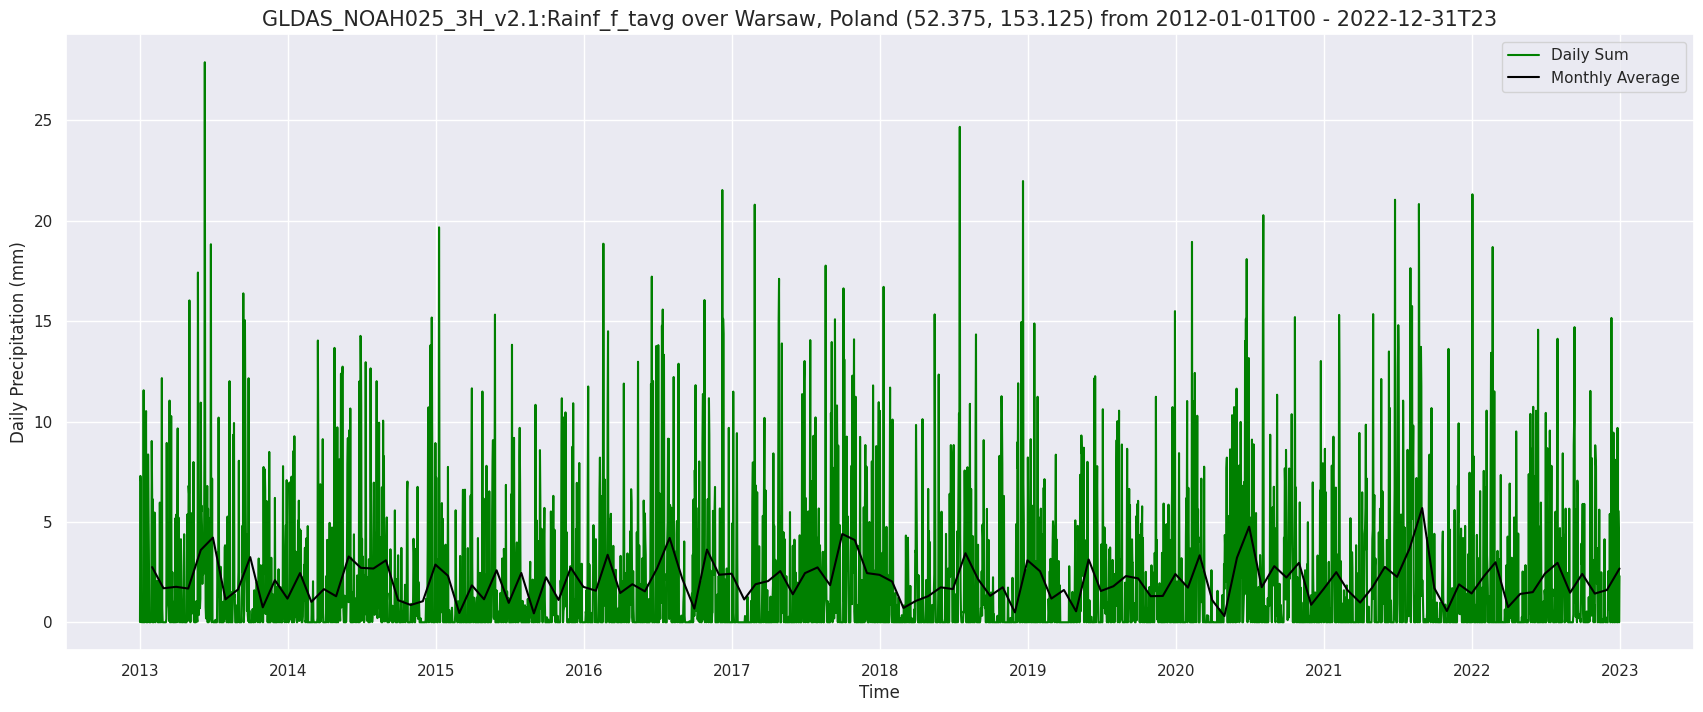

In [20]:
plt.figure(figsize=(21, 8))

# Convert to mm, aggregate over days and months
daily_sum = df_ts[1].groupby(pd.Grouper(key='time', freq='1D')).sum()*3*3600
month_mean = (df_ts[1].groupby(pd.Grouper(key='time', freq='1D')).sum()*3*3600).resample("M").mean()

daily_sum = daily_sum.reset_index()
month_mean = month_mean.reset_index()

plt.plot(daily_sum["time"], daily_sum["data"], color="green")
plt.plot(month_mean["time"], month_mean["data"], color="black")

plt.title("GLDAS_NOAH025_3H_v2.1:Rainf_f_tavg over Warsaw, Poland (52.375, 153.125) from 2012-01-01T00 - 2022-12-31T23", size=15)
plt.ylabel("Daily Precipitation (mm)")
plt.xlabel("Time")
plt.legend(["Daily Sum", "Monthly Average"])

#### Add year and month columns to our daily sums dataframe

In [21]:
daily_sum['year'] = ""
daily_sum['month'] = ""
daily_sum['year_ix'] = ""

for i in range(len(daily_sum)):
    daily_sum['year'].iloc[i] = daily_sum['time'].iloc[i].year
    daily_sum['month'].iloc[i] = daily_sum['time'].iloc[i].month

#### Create a Pandas pivot table, aggregate our daily sum values by month

In [12]:
months_pivot = daily_sum.pivot_table(index = "year", values="data", columns="month", aggfunc=np.sum)
months_pivot

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2013,85.17312,47.35260,54.71820,50.35500,111.56400,126.48960,35.40240,50.65200,97.33500,23.06232,62.89488,36.46080
2014,75.94020,28.42020,51.13260,38.86920,101.56320,81.35640,82.94508,95.64912,32.95728,26.68140,31.43340,89.03520
2015,71.80380,12.88980,56.98728,34.34400,80.24832,28.98504,76.06764,13.75704,67.18464,34.40016,81.57132,54.66852
2016,48.69288,97.48836,45.18288,56.80692,47.71116,80.55180,130.24260,67.52484,20.35260,112.19472,70.97976,74.96820
2017,35.14860,53.05176,63.59796,76.46724,43.22052,73.41192,84.70116,57.18708,131.89500,126.89784,73.45728,73.21212
2018,62.92296,19.94760,33.09876,38.99340,53.89416,49.57956,106.59060,66.56904,39.48048,54.00000,14.74200,95.63724
2019,78.80112,33.01236,49.82688,16.37820,96.92352,46.72620,55.57788,71.34696,65.53548,40.24512,39.32064,74.41632
2020,53.50212,96.69888,33.99624,9.24588,99.65592,142.80192,54.16092,86.59764,66.90816,91.74924,26.12736,51.54408
2021,77.37120,44.60940,30.39012,51.98364,85.46796,67.79484,113.90760,176.31756,51.07104,17.35020,56.62116,44.46576


#### Calculate 10-year z-scores of total monthly precipitation for our Warsaw grid

In [17]:
# Copy pivot table that will serve as our z-scores table
months_zscore = months_pivot.astype('float64')

for yr_ix in range(2013, 2023):
    for mo in range(1, 13):
        months_zscore[mo][yr_ix] = (months_pivot[mo][yr_ix] - months_pivot[mo].mean()) / months_pivot[mo].std()

#### Plot these results using a Seaborn "heatmap"

Text(0.5, 0.98, 'GLDAS Monthly Z-Scores of Total Precipitation in Warsaw, 2013-2022')

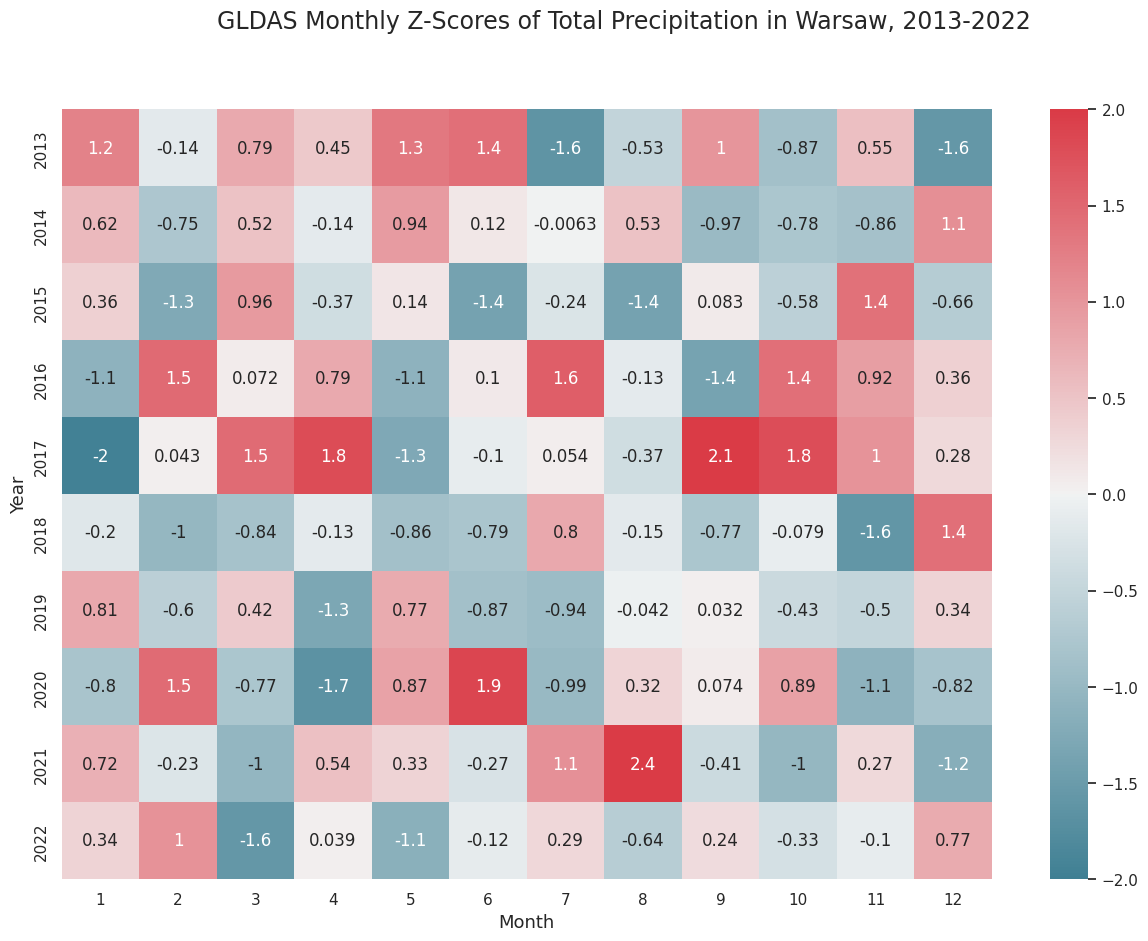

In [19]:
fig, ax = plt.subplots(figsize=(15, 10))
diverge = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(months_zscore, cmap=diverge, center=0, vmin=-2, vmax=2, annot=True)
ax.set_xlabel("Month", fontsize=13)
ax.set_ylabel("Year", fontsize=13)

fig.suptitle("GLDAS Monthly Z-Scores of Total Precipitation in Warsaw, 2013-2022", fontsize=17)